# KSA: Polar Observations and Modelling

## Week 6 - Gridded data

We've done an initial exploring of EN4.2.2., doing some basic plots to try to understand changes throughout time in `1_Introduction_to_EN422.ipynb`.

Now we will look at changes in a bit more robust way: by computing linear trends. We will use the `xarrayMannKendall` library, which provides a really easy way to compute linear trends and significance in gridded products.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [5]:
import os
os.chdir('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class3/')

In [45]:
EN422 = xr.open_dataset('data/EN422_annual_averages_1970-2021.nc')
EN422['temperature'] = EN422['temperature'] - 273.15

Do you remember why we are substracting 273.15 from the temperature?

# Surface properties trends

Let's begin by looking at the trends in surface temperature and salinity:

In [46]:
surface_temp = EN422['temperature'].isel(depth = 0)
surface_salt = EN422['salinity'].isel(depth = 0)

Now we can use `xarrayMannKendall` to calculate linear trends. We need to specify the dimension along which we want to calculate the trends. In our case, it will be the dimension `time`. And we also need to tell the library how are the `x`, `y` dimensions called. In our case, these are `lat` and `lon`. 

In [47]:
MK_class = xrmk.Mann_Kendall_test(surface_temp, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
surface_temp_trends = MK_class.compute()

# The results are given with x, y dimensions. Let's rename them back to lat, lon
surface_temp_trends = surface_temp_trends.rename({'x':'lon', 'y':'lat'})

Let's see what this has returned:

In [11]:
surface_temp_trends

<xarray.Dataset> Size: 566kB
Dimensions:    (lat: 49, lon: 360)
Coordinates:
  * lon        (lon) float32 1kB -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * lat        (lat) float32 196B -83.0 -82.0 -81.0 -80.0 ... -37.0 -36.0 -35.0
Data variables:
    trend      (lat, lon) float64 141kB 0.0 0.0 0.0 ... 0.002357 0.001187
    signif     (lat, lon) float64 141kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    p          (lat, lon) float64 141kB 1.0 1.0 1.0 1.0 ... 0.2867 0.6529 0.9937
    std_error  (lat, lon) float64 141kB 0.0 0.0 0.0 ... 0.007565 0.007463

We have obtained a dataset with the following variables:

- One called `trend` which has the information we are after. The units of these trends are given in the units of our variable ($C$) over the amount of time between timesteps (1 year). Therefore, the trends are in $C/yr$.
- We also have a `signif` variable, which is an array that contains 1s where the trend is significant and 0s where it is not.
- A `p` variable with the our p-values, another measure of statistical significance. You can use p-values to determine a levels of confidence (for example, p-values of less than 0.1 means the trend is significant with 90% confidence).
- And a `std_error` variable, with the standard error in the calculation.

Let's plot our trends:

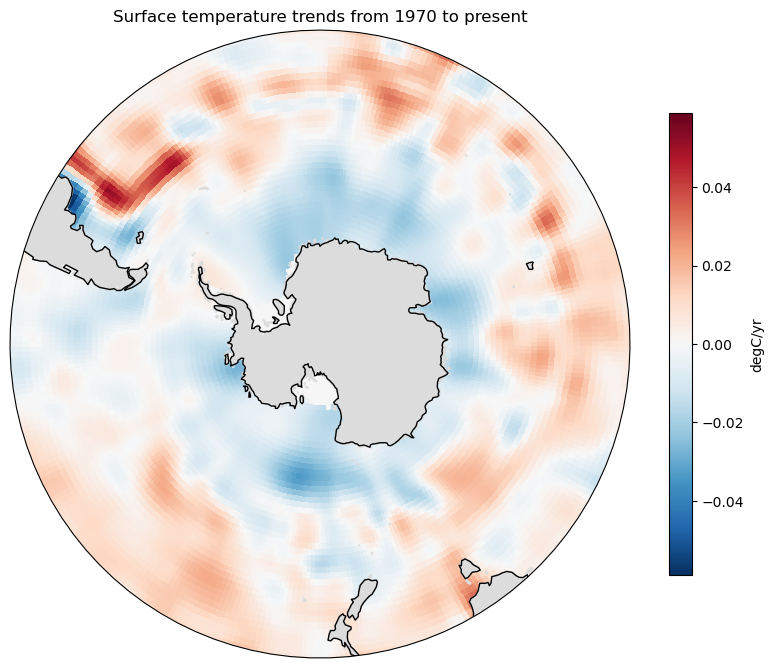

In [48]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='gainsboro',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "110m")
# Map the plot boundaries to a circle
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

surface_temp_trends['trend'].plot(ax = ax, transform = ccrs.PlateCarree(),
                                  cbar_kwargs = {'label': 'degC/yr', 'shrink':.6})

plt.title('Surface temperature trends from 1970 to present');

A usual way of showing trends is to "hatch", or cross-out, the figure where the trends are *not significant*. Remember that this is where our `signif` variable has 0s.

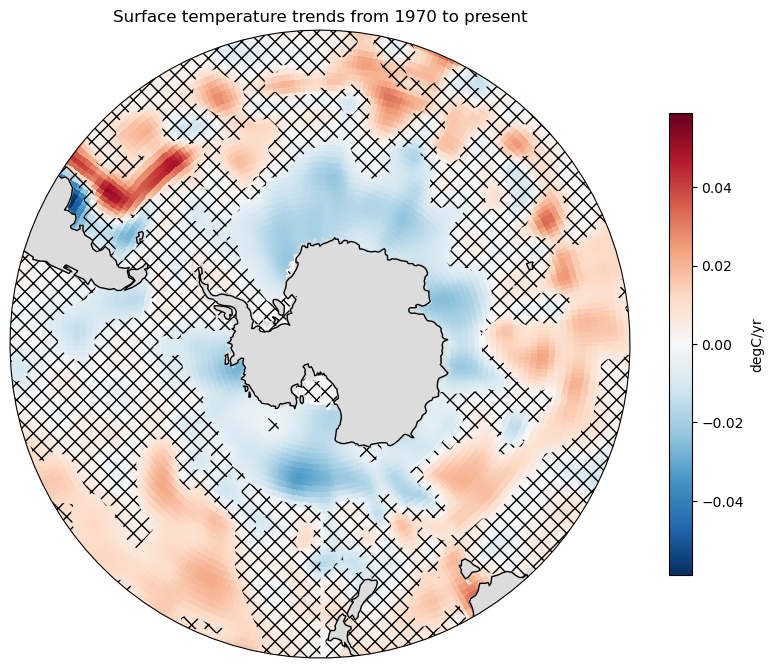

In [49]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='gainsboro',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "110m")
# Map the plot boundaries to a circle
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

surface_temp_trends['trend'].plot(ax = ax, transform = ccrs.PlateCarree(),
                                  cbar_kwargs = {'label': 'degC/yr', 'shrink':.6})

# Add hatching
non_significant_trends = surface_temp_trends['signif'].where(surface_temp_trends['signif'] == 0)
non_significant_trends.plot.contourf(ax = ax, transform = ccrs.PlateCarree(), 
                                     add_colorbar = False, colors = ['none'], hatches = ['xx'])

plt.title('Surface temperature trends from 1970 to present');

#### Question 1

There is significant cooling of the temperatures at the surface in the Southern Ocean around the Antarctic continental margin. Does this surprise you? Do you have any ideas as to what might be happening?

Compute surface salinity trends as well to complement your discussion.

*Answer here*

# Bottom properties trends

We have taken a look at what's happening at the surface of the ocean. What about the bottom? 

Getting bottom properties is a bit more tricky than selecting the surface. Remember that to select surface temperatures, we had used `.isel(depth = 0)` to grab the first depth level. If in analogy we used `.isel(depth = -1)` to select the last depth level, we would be encountering a problem. The ocean's depth is not constant, so while the deepest basins will have information in the last level, a lot of shallower regions won't. Take a look:

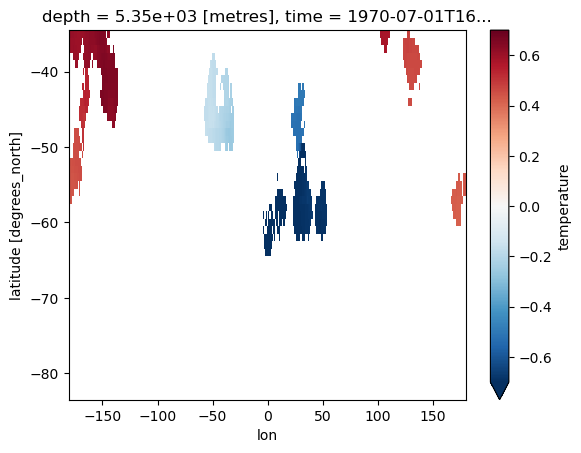

In [93]:
EN422['temperature'].isel(depth = -1, time = 0).plot(vmin = -.7, vmax = .7, cmap = 'RdBu_r');

So what we actually need to select is the *last level at which we have temperature information*. 

A way of doing that is to create a mask that has 1s where we have temperature data, and 0s over land. Then we can do a cumulative sum from the surface down, which will reach a maximum once we get to the bottom and start adding 0s. Then we just select the maxium of the cumulative sum, and evaluate our temperatures at that maximum. And voila! Now we have bottom temperatures.

In [84]:
# Create a mask with 1s where we have temperature data, 0s otherwise
mask = xr.where(np.isnan(EN422['temperature']), 0, 1)

# Do a cumulative sum along the depth dimension
mask = mask.cumsum('depth')

# Select the maximum 
bottom_level = mask.argmax('depth')

In [85]:
bottom_temperature = EN422['temperature'].isel(depth = bottom_level)

Let's calculate the trends:

In [86]:
MK_class = xrmk.Mann_Kendall_test(bottom_temperature, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
bottom_temperature_trends = MK_class.compute()

# The results are given with x, y dimensions. Let's rename them back to lat, lon
bottom_temperature_trends = bottom_temperature_trends.rename({'x':'lon', 'y':'lat'})

And now plot them:

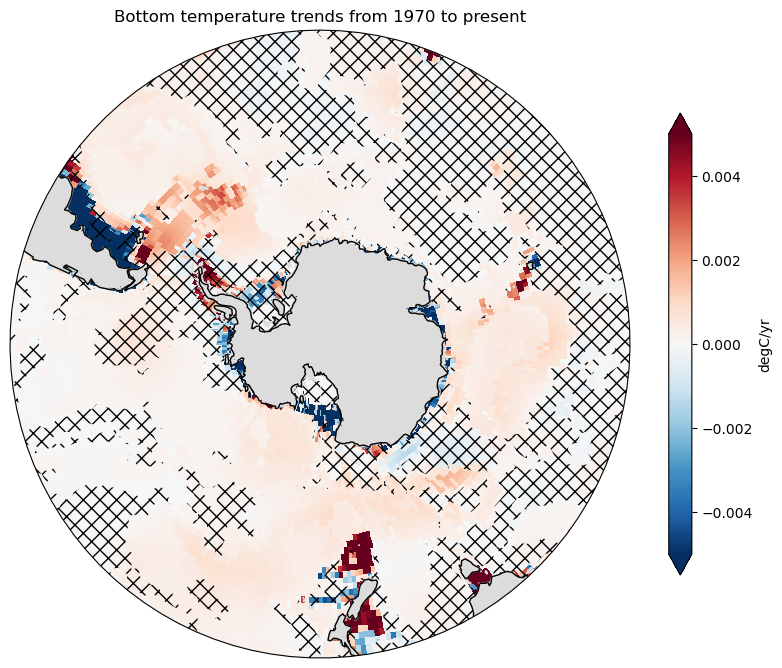

In [91]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='gainsboro',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "110m")
# Map the plot boundaries to a circle
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

bottom_temperature_trends['trend'].plot(ax = ax, transform = ccrs.PlateCarree(), vmin = -.005, vmax = .005, cmap = 'RdBu_r',
                                        cbar_kwargs = {'label': 'degC/yr', 'shrink':.6})

# Add hatching
non_significant_trends = bottom_temperature_trends['signif'].where(bottom_temperature_trends['signif'] == 0)
non_significant_trends.plot.contourf(ax = ax, transform = ccrs.PlateCarree(), 
                                     add_colorbar = False, colors = ['none'], hatches = ['xx'])

plt.title('Bottom temperature trends from 1970 to present');

Note how the magnitude of the changes is a couple of times smaller than the changes at the surface. This is to be expected, because the rate at which the abyssal ocean communicates with the surface, through where "information" about global warming is coming, is really really small. Changes in the bottom of the ocean are slow to come and spread, but are nevertheless a symptom of climate change. 

Take a look at the paper of [Purkey and Johnson (2010)](https://journals.ametsoc.org/view/journals/clim/23/23/2010jcli3682.1.xml), or the more recent [Li et al. (2023)](https://www.nature.com/articles/s41586-023-05762-w) if you are interested in reading more about these changes.

#### Question 2 

Calculate bottom salinity trends and discuss the results. 


*Tip: you can use the same `bottom_level` we used for temperature.*

*Answer here*

# Zonal average trends

We have looked at the surface and bottom properties trends. Now let's look at the trends at different levels in the water column by calculating the trends of a zonal average. 

In [94]:
zonal_avg_temperature = EN422['temperature'].mean('lon')

Note that now to calculate the trends, our `x` dimension will be latitude, and `y` will be depth. We no longer have a longitude dimension!

In [96]:
MK_class = xrmk.Mann_Kendall_test(zonal_avg_temperature, 'time', coords_name = {'time':'time', 'depth':'y', 'lat':'x'})
zonal_avg_temperature_trends = MK_class.compute()

# The results are given with x, y dimensions. Let's rename them back to lat, lon
zonal_avg_temperature_trends = zonal_avg_temperature_trends.rename({'x':'lat', 'y':'depth'})

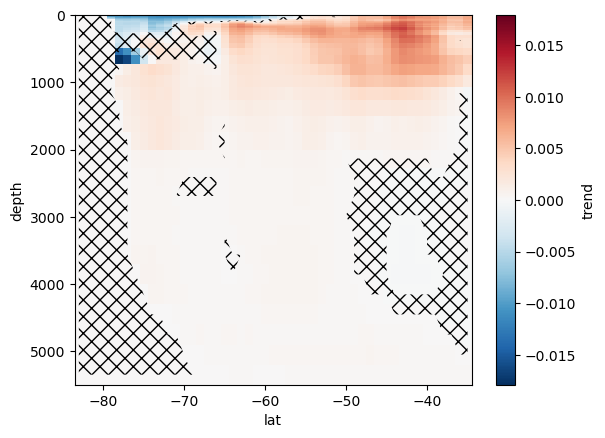

In [103]:
zonal_avg_temperature_trends['trend'].plot(cmap = 'RdBu_r');

# Add hatching
non_significant_trends = zonal_avg_temperature_trends['signif'].where(zonal_avg_temperature_trends['signif'] == 0)
non_significant_trends.plot.contourf(add_colorbar = False, colors = ['none'], hatches = ['xx'])

plt.gca().invert_yaxis()

Doesn't look quite nice! All that hatching on the left is actually land. So let's mask our `zonal_avg_temperature_trends` and put `NaN`s in land.

In [107]:
zonal_avg_temperature_trends = xr.where(np.isnan(zonal_avg_temperature.isel(time = 0)), np.nan, zonal_avg_temperature_trends)

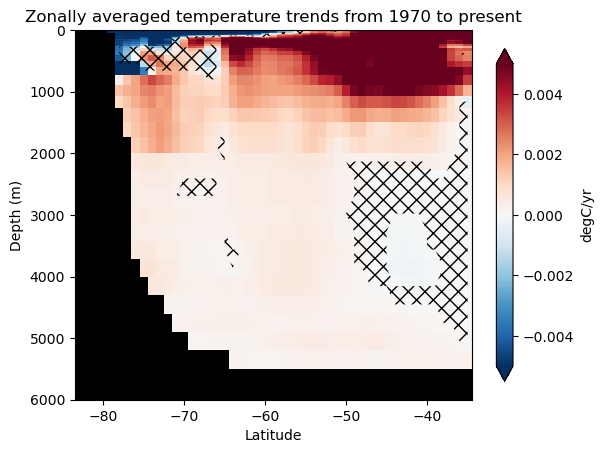

In [122]:
zonal_avg_temperature_trends['trend'].plot(cmap = 'RdBu_r', vmin = -.005, vmax = .005, cbar_kwargs = {'label': 'degC/yr', 'shrink':.9});

# Add hatching
non_significant_trends = zonal_avg_temperature_trends['signif'].where(zonal_avg_temperature_trends['signif'] == 0)
non_significant_trends.plot.contourf(add_colorbar = False, colors = ['none'], hatches = ['xx'])

plt.gca().invert_yaxis()
plt.ylim(6000, None)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)');   
plt.gca().set_facecolor('k');
plt.title('Zonally averaged temperature trends from 1970 to present');

#### Question 3

Again, repeat the analysis for salinity and discuss the observed trends.

*Answer here*